In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy
from matplotlib import pyplot as plt


In [2]:
vgg16 = torchvision.models.vgg16()

In [3]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
mnist_train_data=torchvision.datasets.MNIST('./',transform=torchvision.transforms.ToTensor(),download=True)

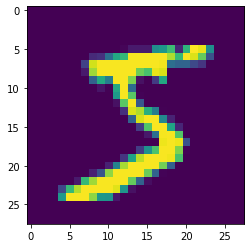

In [5]:
plt.imshow(mnist_train_data.data[0])

In [6]:
# Variational Auto Encoder 구현해보기
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [7]:
config=Config({'batch_size':16,'hidden_dim':128,'input_size':28,'device':torch.device('cuda' if torch.cuda.is_available() else 'cpu')})

In [8]:
train_data_loader=torch.utils.data.DataLoader(mnist_train_data,batch_size=config.batch_size,shuffle=True,drop_last=True)

In [9]:
batch=next(iter(train_data_loader))

In [10]:
batch[0].shape

torch.Size([16, 1, 28, 28])

In [11]:
class encoding(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.fc=nn.Sequential(nn.Linear(self.config.input_size*self.config.input_size,2*self.config.hidden_dim),nn.ReLU())
        self.Mu=nn.Linear(2*self.config.hidden_dim,self.config.hidden_dim)
        self.Log_var=nn.Linear(2*self.config.hidden_dim,self.config.hidden_dim) # log var로 하는 것이, 범위 조건이 없으므로
        
    def forward(self,data):
        x=data.reshape(-1,self.config.input_size*self.config.input_size) # batch_size, input_size*input_size
        x=self.fc(x)
        mu=self.Mu(x)
        log_var=self.Log_var(x)
        return mu,log_var
    
class decoding(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.fc1=nn.Sequential(nn.Linear(self.config.hidden_dim,2*self.config.hidden_dim),nn.ReLU())
        self.fc2=nn.Linear(2*self.config.hidden_dim,self.config.input_size*self.config.input_size,nn.Sigmoid())
    def forward(self,z):
        x=self.fc1(z)
        output=self.fc2(x)
        return output

In [16]:
class variational_auto_encoder(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.encoder=encoding(config)
        self.decoder=decoding(config)
    
    def forward(self,data):
        self.mu,self.log_var=self.encoder(data)
        sigma=torch.exp(0.5*self.log_var).to(device)
        e=torch.randn_like(sigma).to(device)
        z=self.mu+sigma*e
        output=self.decoder(z)
        return output,self.mu,self.log_var


In [17]:
def train():
    optimizer.zero_grad()
    y,mu,log_var=model.forward(x) # x shape : batch_size, input_channel, h,w
    x_=x.reshape(config.batch_size,-1)
    # cost를 mse로 쓰면, 그냥 평균적으로 흐리흐리하게 나오는 꼴이 된다.
    cost=F.binary_cross_entropy(y,x_,reduction='sum')+0.5*(torch.sum(mu**2+log_var.exp()-log_var-1))
    loss.append(cost.item())
    cost.backward()
    optimizer.step()   

In [14]:
def test(test_data):
    with torch.no_grad():
        y,mu,sigma=model.forward(test_data)
        z=mu+sigma*torch.randn(config.batch_size,config.hidden_dim).to(config.device)
        output=model.decoder(z)
        return output,mu,sigma

In [18]:
import time
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=variational_auto_encoder(config).to(device)
loss=[]
optimizer=torch.optim.Adam(model.parameters(),0.01)
epoch=10

for i in range(epoch):
    now=time.time()
    print(i)
    
    for x,y in train_data_loader:
        x=x.to(device)
        y=y.to(device)
        train()
    print(time.time()-now)        

0


RuntimeError: reduce failed to synchronize: cudaErrorAssert: device-side assert triggered

In [ ]:
a,b,c=test(batch[0].to(device))

In [ ]:
print(a)
print(b)
print(c)

In [ ]:
c # 분산이 거의 -0???

In [ ]:
for i in range(16):
    plt.imshow(a.to('cpu')[i,:].reshape(28,28))
    plt.show()
    plt.imshow(batch[0][i,:].reshape(28,28))
    plt.show()

In [ ]:
# 실제 데이터를 생성해낼 때엔 decoder 부분만 check하면 될듯
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=variational_auto_encoder(config).to(device)
y,mu,sigma=model.forward(batch[0].to(device))
x=batch[0].to(device)
x_=x.reshape(config.batch_size,config.input_size*config.input_size)
duplicated_x_=x_.repeat(config.random_num,1,1)
print(F.mse_loss(y,duplicated_x_,reduction='sum'))
print(-0.5*(torch.sum(mu**2+sigma**2-torch.log(sigma**2++))))
print(mu)
print(torch.log(sigma**2))

In [ ]:
batch[0][0]

In [ ]:
input = torch.randn((3, 4), requires_grad=True)
target = torch.rand((3, 4), requires_grad=False)
loss = F.binary_cross_entropy(F.sigmoid(input), target)
print(input)
print(target)
print(loss)

In [ ]:
input=torch.tensor([1,2,3,4.]).reshape(2,2) # batch size 2

print(F.binary_cross_entropy(F.sigmoid(input),F.sigmoid(input)))
print(input)
# F.binary_cross_entropy()
print(F.sigmoid(input))
-0.7311*torch.log(torch.tensor(0.7311))-0.8808*torch.log(torch.tensor(0.8808))-0.9526*torch.log(torch.tensor(0.9526))-0.9820*torch.log(torch.tensor(0.9820))